In [70]:
import sys
from collections import defaultdict
import numpy as np
import pandas as pd
import tensorflow as tf

import tensorflow as tf
import tensorflow.keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
import time
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalMaxPooling1D, concatenate,Flatten,Dropout, Activation, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import glorot_normal
from tensorflow.keras.activations import sigmoid
from sklearn.metrics import roc_auc_score
# import utils
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf


In [77]:
def nettcr_ab():
    '''NetTCR ab with the "correct" pooling dimension, that is: the three towers are convoluted, then pooled
       and then concatenated for the FNN'''
    
    ept_in = Input(shape=(13,20))
    cdra_in = Input(shape=(32,20))
    cdrb_in = Input(shape=(32,20))
    
    cdra_conv1 = Conv1D(16, 1, padding='same', activation='sigmoid', kernel_initializer='glorot_normal')(cdra_in)
    cdra_pool1 = GlobalMaxPooling1D()(cdra_conv1)
    cdra_conv3 = Conv1D(16, 3, padding='same', activation='sigmoid', kernel_initializer='glorot_normal')(cdra_in)
    cdra_pool3 = GlobalMaxPooling1D()(cdra_conv3)
    cdra_conv5 = Conv1D(16, 5, padding='same', activation='sigmoid', kernel_initializer='glorot_normal')(cdra_in)
    cdra_pool5 = GlobalMaxPooling1D()(cdra_conv5)
    cdra_conv7 = Conv1D(16, 7, padding='same', activation='sigmoid', kernel_initializer='glorot_normal')(cdra_in)
    cdra_pool7 = GlobalMaxPooling1D()(cdra_conv7)
    
    cdrb_conv1 = Conv1D(16, 1, padding='same', activation='sigmoid', kernel_initializer='glorot_normal')(cdrb_in)
    cdrb_pool1 = GlobalMaxPooling1D()(cdrb_conv1)
    cdrb_conv3 = Conv1D(16, 3, padding='same', activation='sigmoid', kernel_initializer='glorot_normal')(cdrb_in)
    cdrb_pool3 = GlobalMaxPooling1D()(cdrb_conv3)
    cdrb_conv5 = Conv1D(16, 5, padding='same', activation='sigmoid', kernel_initializer='glorot_normal')(cdrb_in)
    cdrb_pool5 = GlobalMaxPooling1D()(cdrb_conv5)
    cdrb_conv7 = Conv1D(16, 7, padding='same', activation='sigmoid', kernel_initializer='glorot_normal')(cdrb_in)
    cdrb_pool7 = GlobalMaxPooling1D()(cdrb_conv7)

    cdra_cat = concatenate([cdra_pool1, cdra_pool3, cdra_pool5, cdra_pool7])
    cdrb_cat = concatenate([cdrb_pool1, cdrb_pool3, cdrb_pool5, cdrb_pool7])
    print(cdra_conv1.shape)
    print(cdra_pool1.shape)
    cat = concatenate([cdra_cat, cdrb_cat], axis=1)
    print(cat.shape)
    
    dense = Dense(128, activation='sigmoid')(cat)
    dense = Dense(260, activation='sigmoid')(dense)
    dense = Dense(260, activation= None)(dense)
    #drop = Dropout(0.3)(dense)
    
    out = Reshape((13,20))(dense)
    print(out.shape)
    model = (Model(inputs=[cdra_in, cdrb_in],outputs=[out]))
    
    return model

In [94]:
mdl=nettcr_ab()
mdl.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.001))

(None, 32, 16)
(None, 16)
(None, 128)
(None, 13, 20)


# data

In [79]:
## load dataset & filter out missing data
# dbfile = pd.read_csv('./Data/vdjdb.slim.txt', sep='\t')
dbfile = pd.read_csv('./Data/VDJDB/vdjdb_full.txt', sep='\t')
# print(dbfile.columns)
dbfile = dbfile[['cdr3.alpha', 'cdr3.beta','antigen.epitope','antigen.species',"mhc.class"]]
print(dbfile.shape)
dbfile = dbfile.dropna(subset=['cdr3.alpha', 'cdr3.beta','antigen.epitope'])
print(dbfile.shape)
dbfile.head()

(60055, 5)
(29266, 5)


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (20,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,cdr3.alpha,cdr3.beta,antigen.epitope,antigen.species,mhc.class
0,CIVRAPGRADMRF,CASSYLPGQGDHYSNQPQHF,FLKEKGGL,HIV-1,MHCI
2,CAVPSGAGSYQLTF,CASSFEPGQGFYSNQPQHF,FLKEKGGL,HIV-1,MHCI
3,CAVKASGSRLT,CASSYEPGQVSHYSNQPQHF,FLKEKGGL,HIV-1,MHCI
4,CAYRPPGTYKYIF,CASSALASLNEQFF,FLKEKGGL,HIV-1,MHCI
5,CIVRAPGRADMRF,CASSYLPGQGDHYSNQPQHF,FLKEQGGL,HIV-1,MHCI


In [80]:
iedbfile = pd.read_csv('./Data/IEDB/tcell_receptor_table_export_1668026760.csv')
# print(iedbfile.columns)
# Chain 1 Full Sequence', 'Chain 1 Accession', 'Chain 1 CDR3 Curated',
#        'Chain 1 CDR3 Calculated'
iedbfile = iedbfile[['Chain 1 CDR3 Curated','Chain 2 CDR3 Curated',"Description","Organism"]]
print(iedbfile.shape)
iedbfile = iedbfile.dropna(subset=['Chain 1 CDR3 Curated','Chain 2 CDR3 Curated',"Description"])
iedbfile.Description = iedbfile.Description.str.split(' ').str[0]
iedbfile = iedbfile[~iedbfile.Description.str.contains('[^ARNDCQEGHILKMFPSTWYV]',na=False)]
print(iedbfile.shape)
iedbfile.head()

(205824, 4)
(25927, 4)


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (8,10,11,13,15,16,17,18,19,20,21,22,23,24,25,30,31,36,37,42,44,45,46,47,48,49,50,51,52,53,54,59,60,65,66) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Chain 1 CDR3 Curated,Chain 2 CDR3 Curated,Description,Organism
0,IVVRSSNTGKLI,ASSQDRDTQY,VMAPRTLIL,Homo sapiens (human)
80,CAVTTDSWGKLQF,CASRPGLAGGRPEQYF,LLFGYPVYV,Human T-cell leukemia virus type I (Human T ce...
82,CAVTTDSWGKLQF,CASRPGLMSAQPEQYF,LLFGYPVYV,Human T-cell leukemia virus type I (Human T ce...
109,CAVRPTSGGSYIPTF,CASSYVGNTGELFF,SLLMWITQC,Homo sapiens (human)
202,TVYGGATNKLI,SARGGSYNSPLH,LSRFSWGAEGQRPGFGYGG,Homo sapiens (human)


In [81]:
# print(len(train['antigen.epitope']))
# print(sum(train['antigen.epitope']=="GILGFVFTL"))
# for i in set(train['antigen.epitope']):
#     train['antigen.epitope'].count(i)
dbfile = dbfile.drop_duplicates(subset=['cdr3.alpha', 'cdr3.beta','antigen.epitope'])
dbfile = dbfile.drop(dbfile.query('`antigen.epitope` == "KLGGALQAK"').sample(frac=.87).index)

In [82]:
from functions import load

In [83]:
from importlib import reload
reload(load)

<module 'functions.load' from 'C:\\Users\\zjin75\\OneDrive - Emory University\\Emory\\Classes\\2022 fall\\BMI536 DL\\final\\CDR2EPI\\functions\\load.py'>

In [84]:
print(dbfile.head(n=2)["cdr3.alpha"])
load.enc_list_bl_max_len(dbfile.head(n=2)["cdr3.alpha"],30).shape

0     CIVRAPGRADMRF
2    CAVPSGAGSYQLTF
Name: cdr3.alpha, dtype: object


(2, 30, 20)

In [85]:
tokens = load.blosum50_20aa.keys()

tokens = list(tokens)
tokens.insert(0, '.')
tokens.insert(1, '>')
tokens.insert(2, '<')
tk_dict = defaultdict(lambda: None)
for idx in range(len(tokens)):
    tk_dict[tokens[idx]]=idx
vocabSize=23

In [86]:
load.positional_coding(dbfile.head(n=52)["cdr3.alpha"],tk_dict,30).shape
load.positional_coding(iedbfile.head(n=52)["Chain 1 CDR3 Curated"],tk_dict,30).shape

(52, 30)

In [87]:
from sklearn.model_selection import train_test_split

In [88]:
train, test = train_test_split(dbfile[dbfile['antigen.epitope'].str.len()<=12], shuffle=True ,test_size=0.2)

In [124]:
tcra_train = np.roll(load.enc_list_bl_max_len(train["cdr3.alpha"], 32), shift=1, axis=1)
tcra_test = np.roll(load.enc_list_bl_max_len(test["cdr3.alpha"], 32), shift=1, axis=1)
tcrb_train = np.roll(load.enc_list_bl_max_len(train["cdr3.beta"], 32), shift=1, axis=1)
tcrb_test = np.roll(load.enc_list_bl_max_len(test["cdr3.beta"], 32), shift=1, axis=1)
# ept_train = np.roll(ept_train, 1)

ept_train_lb = load.enc_list_bl_max_len(train['antigen.epitope'], 13)
ept_test_lb = load.enc_list_bl_max_len(test['antigen.epitope'], 13)

ept_train = np.roll(ept_train_lb, shift=1, axis=1)
ept_test = np.roll(ept_test_lb, shift=1, axis=1)

train_inputs = [tcra_train, tcrb_train]
test_inputs = [tcra_test,tcrb_test]

y_train=ept_train
y_test=ept_test

validation_inputs=(test_inputs,y_test)

In [123]:
tcra_test.shape

(3172, 32, 20)

In [118]:
print(tcra_train.shape)
print(tcrb_train.shape)
print(ept_train.shape)
print(tcra_test.shape)
print(tcrb_test.shape)
print(ept_test.shape)

(12687, 32, 20)
(12687, 32, 20)
(12687, 13, 20)
(3172, 32, 20)
(3172, 32, 20)
(3172, 13, 20)


# train

In [91]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [92]:
early_stop = EarlyStopping(monitor='loss',min_delta=0,
               patience=10, verbose=0,mode='min',restore_best_weights=True)

In [113]:
mdl=nettcr_ab()
mdl.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.001))

(None, 32, 16)
(None, 16)
(None, 128)
(None, 13, 20)


In [125]:
print('Training..')
# Train
history = mdl.fit(train_inputs, y_train, 
                  epochs=100, batch_size=64, verbose=1, callbacks=[early_stop],
                  validation_data= (validation_inputs))

Training..
Epoch 1/100
199/199 [==============================] - 2s 8ms/step - loss: 3.7093 - val_loss: 3.6545
Epoch 2/100
199/199 [==============================] - 1s 6ms/step - loss: 3.6681 - val_loss: 3.6120
Epoch 3/100
199/199 [==============================] - 1s 7ms/step - loss: 3.5827 - val_loss: 3.5184
Epoch 4/100
199/199 [==============================] - 1s 7ms/step - loss: 3.5271 - val_loss: 3.4895
Epoch 5/100
199/199 [==============================] - 1s 7ms/step - loss: 3.5000 - val_loss: 3.4746
Epoch 6/100
199/199 [==============================] - 1s 7ms/step - loss: 3.4685 - val_loss: 3.4745
Epoch 7/100
199/199 [==============================] - 1s 7ms/step - loss: 3.4504 - val_loss: 3.4291
Epoch 8/100
199/199 [==============================] - 1s 7ms/step - loss: 3.4227 - val_loss: 3.4083
Epoch 9/100
199/199 [==============================] - 1s 7ms/step - loss: 3.3957 - val_loss: 3.3888
Epoch 10/100
199/199 [==============================] - 1s 7ms/step - loss: 3.35

199/199 [==============================] - 1s 7ms/step - loss: 2.6774 - val_loss: 3.2042
Epoch 82/100
199/199 [==============================] - 1s 7ms/step - loss: 2.6663 - val_loss: 3.2323
Epoch 83/100
199/199 [==============================] - 1s 7ms/step - loss: 2.6696 - val_loss: 3.2400
Epoch 84/100
199/199 [==============================] - 1s 7ms/step - loss: 2.6624 - val_loss: 3.2268
Epoch 85/100
199/199 [==============================] - 1s 7ms/step - loss: 2.6617 - val_loss: 3.2329
Epoch 86/100
199/199 [==============================] - 1s 7ms/step - loss: 2.6604 - val_loss: 3.2035
Epoch 87/100
199/199 [==============================] - 1s 7ms/step - loss: 2.6504 - val_loss: 3.2114
Epoch 88/100
199/199 [==============================] - 1s 7ms/step - loss: 2.6421 - val_loss: 3.2246
Epoch 89/100
199/199 [==============================] - 2s 8ms/step - loss: 2.6445 - val_loss: 3.2454
Epoch 90/100
199/199 [==============================] - 1s 7ms/step - loss: 2.6509 - val_loss: 

In [134]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


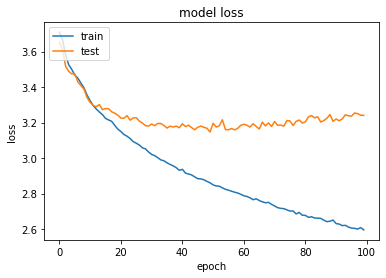

In [135]:
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# CV

In [ ]:
train, test = train_test_split(dbfile[dbfile['antigen.epitope'].str.len()<=12], shuffle=True ,test_size=0.2)